# Tensorflow

---

# Library

In [1]:
import tensorflow as tf
# from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
import time
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam

import numpy as np
import seaborn as sns
import time

import matplotlib.pyplot as plt
plt.style.use('ggplot')

We need to free gpu, because Tensorflow allocate most of GPU memory. If it has error restart the kernel to make sure free all gpu.

In [2]:
from numba import cuda

# free gpu
cuda.select_device(0)
cuda.close()

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


# Load data
We load data which is preprocessed before.

In [3]:
import pickle
with open('../data/preprocessed_data.pkl', 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

We need to check if gpu is available.

In [4]:
print("CUDA available:", tf.test.is_built_with_cuda())
print("GPU available:", tf.config.list_physical_devices('GPU'))

CUDA available: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In TensorFlow, we prepare our data by converting it into `tf.Tensor` format for compatibility with TensorFlow operations. We then create `Dataset` objects for training, validation, and testing by pairing the input features and labels.

In [5]:
# convert data to tensor
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_tensor, y_test_tensor))

BATCH_SIZE = 128
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

print(f"Train Loader Batches: {len(train_dataset)}")
print(f"Validation Loader Batches: {len(val_dataset)}")
print(f"Test Loader Batches: {len(test_dataset)}")


Train Loader Batches: 313
Validation Loader Batches: 79
Test Loader Batches: 79


# Model design

We will construct the model with the following architecture:
- Hidden Layers: Two layers with 256 and 128 neurons, respectively.
- Activation Function: ReLU (Rectified Linear Unit).
- Optimizer: Adam.
- Batch Size: 128.
- Learning Rate: Initial value of 0.001, decreasing by 0.1% every 10 epochs.
- Maximum Iterations: 200.
- Early Stopping: Stop training if the loss does not improve within 10 epochs.

**ReLU Activation Function**

The formula for the ReLU (Rectified Linear Unit) activation function is:

$$
f(x) = \max(0, x)
$$

**Explanation**:
- If \(x > 0\), the output is \(x\).
- If \(x $\leq$ 0\), the output is \(0\).

ReLU helps introduce non-linearity into the network and avoids the vanishing gradient problem commonly encountered with Sigmoid or Tanh activations.


In [6]:
input_size = X_train.shape[1]

# hidden layers
model = tf.keras.models.Sequential([
  Dense(256, activation='relu', input_shape=(input_size,)),
#   BatchNormalization(),
  Dense(128, activation='relu'),
  Dense(10, activation='softmax')
])                   

# # output layer
# model.add(Dense(10, activation='softmax'))     

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               786688    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
_________________________________________________________________


## Selecting Loss Function and Optimizer


We use the `Adam` optimizer with a learning rate of 0.001 to update the model's weights efficiently during training. The loss function, set `'categorical_crossentropy'` as `CrossEntropyLoss`.

# Selecting Loss Function and Optimizer

We use `CrossEntropyLoss` as our loss function. For optimization, we chose the `Adam` optimizer with a learning rate of 0.001, ensuring efficient and adaptive gradient updates. Additionally, we included a `StepLR` scheduler, which reduces the learning rate by a factor of 0.1 every 10 epochs to improve convergence during training.

## CrossEntropyLoss

The formula for CrossEntropyLoss is as follows:

$$
\text{Loss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{ij} \log(\hat{y}_{ij})
$$

1. **Input**: The logits produced by the model $z_i$.
2. **SoftMax Transformation**: Converts logits into probabilities:
   $$
   \hat{y}_{ij} = \frac{e^{z_{ij}}}{\sum_{k=1}^{C} e^{z_{ik}}}
   $$
3. **Loss Calculation**: The negative log of the predicted probability corresponding to the ground truth class is summed and averaged across all samples.

**Explain**:
It calculates the negative log of the predicted probability corresponding to the true class for each sample and the average loss is computed across the entire dataset. The objective is to minimize the loss, indicating that the model's predictions are getting closer to the true labels.

---

Adam Optimizer

The Adam optimizer updates weights using the following formulas:

### Moment Estimation:
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$
$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

### Bias Correction:
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

### Weight Update:
$$
 \theta_t = \theta_{t-1} - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t
$$
1. **Input**: Gradients ($g_t$) calculated during backpropagation.
2. **Moment Calculation**:
   - First moment $m_t$ tracks the mean of past gradients to smooth updates.
   - Second moment $v_t$ tracks the variance to adjust the learning rate dynamically.
3. **Bias Correction**: Corrects for initialization bias in the first few iterations.
4. **Weight Update**: Parameters are updated based on the adjusted learning rates and directions determined by the moments.
<br><br>**Explain**:
- Adam uses two moment estimates:
First Moment (Momentum): stores the exponentially weighted moving average of past gradients.
Second Moment (Variance): stores the exponentially weighted moving average of squared gradients, adjusting the learning rate accordingly.
- Bias Correction: Both moment estimates are bias-corrected to avoid skewed updates, especially in the early stages of training.
- Weight Update: The weights are updated using the bias-corrected moments, with an adaptive learning rate for each parameter.
- Adam combines momentum and adaptive learning rates, helping the model converge faster and more stably during training.



In [7]:
# optimizer
optimizer = Adam(learning_rate=0.001)
loss_function = 'categorical_crossentropy'

## Model Training

We build learning rate scheduling function which reduces the learning rate by a factor of 0.1 every 10 epochs to improve convergence during traning.

In [8]:
def step_decay(epoch, lr):
    step_size = 10  # Number of epochs before reducing the learning rate
    gamma = 0.1     # The decay factor (reduce learning rate to 10% of its current value)
    
    # Check if the current epoch is a multiple of step_size and greater than 0
    # If true, reduce the learning rate; otherwise, keep it the same
    new_lr = lr * gamma if epoch > 0 and epoch % step_size == 0 else lr
    
    # Print the updated learning rate for monitoring
    print(f"Epoch {epoch+1}: Learning Rate = {new_lr:.6f}") 
    return new_lr  # Return the updated learning rate


lr_scheduler = LearningRateScheduler(step_decay)

model.compile(optimizer=optimizer,  # The optimization algorithm to update weights (Adam)
              loss=loss_function,   # The loss function to calculate model error (categorical_crossentropy)
              metrics=['accuracy']) # Metrics to monitor during training

Training process

In [9]:
# Initialize lists to store loss values
cesTrainLoss = []
cesValidLoss = []

# EarlyStopping: Stop training early if the model stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitors the validation loss to decide when to stop
    patience=10,                  # Number of epochs with no improvement before stopping
    min_delta=0.001,              # Minimum change in monitored value to qualify as an improvement
    restore_best_weights=True     # Restores model weights from the epoch with the best validation loss
)

# Mark the start time
start_time = time.time()  # Record the start time of training for tracking duration

# Train the model
history = model.fit(
    train_dataset,                # Training dataset
    validation_data=val_dataset,  # Validation dataset for monitoring performance
    epochs=200,                    # Maximum number of epochs for training
    callbacks=[lr_scheduler, early_stopping],  # Callbacks to control training behavior
    verbose=2                     # Displays detailed output during training (progress for each epoch)
)

# Record the training and validation loss
cesTrainLoss = history.history['loss']          # Training loss
cesValidLoss = history.history['val_loss']      # Validation loss

# Mark the end time
end_time = time.time()

Epoch 1: Learning Rate = 0.001000
Epoch 1/200
313/313 - 5s - loss: 1.9296 - accuracy: 0.3054 - val_loss: 1.8289 - val_accuracy: 0.3415 - lr: 0.0010 - 5s/epoch - 16ms/step
Epoch 2: Learning Rate = 0.001000
Epoch 2/200
313/313 - 2s - loss: 1.7216 - accuracy: 0.3863 - val_loss: 1.7576 - val_accuracy: 0.3708 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 3: Learning Rate = 0.001000
Epoch 3/200
313/313 - 1s - loss: 1.6472 - accuracy: 0.4103 - val_loss: 1.6397 - val_accuracy: 0.4245 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 4: Learning Rate = 0.001000
Epoch 4/200
313/313 - 1s - loss: 1.5809 - accuracy: 0.4378 - val_loss: 1.6023 - val_accuracy: 0.4355 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 5: Learning Rate = 0.001000
Epoch 5/200
313/313 - 1s - loss: 1.5327 - accuracy: 0.4555 - val_loss: 1.5989 - val_accuracy: 0.4319 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 6: Learning Rate = 0.001000
Epoch 6/200
313/313 - 1s - loss: 1.4990 - accuracy: 0.4681 - val_loss: 1.5471 - val_accuracy: 0.4550 - lr: 0.0010 -

In [10]:
# Calculate the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Training time: 53.39 seconds


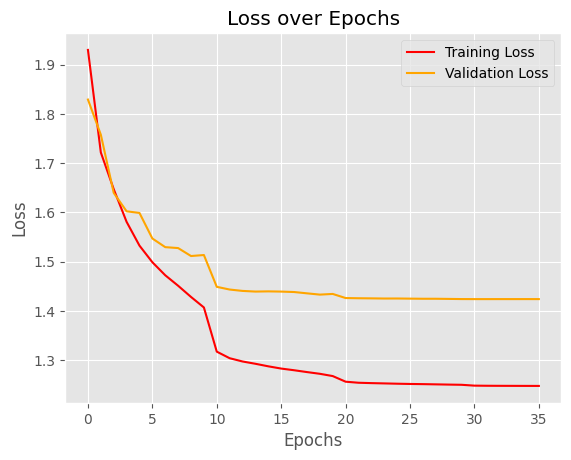

In [11]:
# Plot training and validation losses
plt.plot(cesTrainLoss, label='Training Loss', color='red')  # Training Loss
plt.plot(cesValidLoss, label='Validation Loss', color='orange')  # Validation Loss
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Model Evaluation

79/79 [==============================] - 1s 4ms/step
Accuracy: 0.5062
Precision (macro): 0.5005
Recall (macro): 0.5062
F1-Score (macro): 0.5034


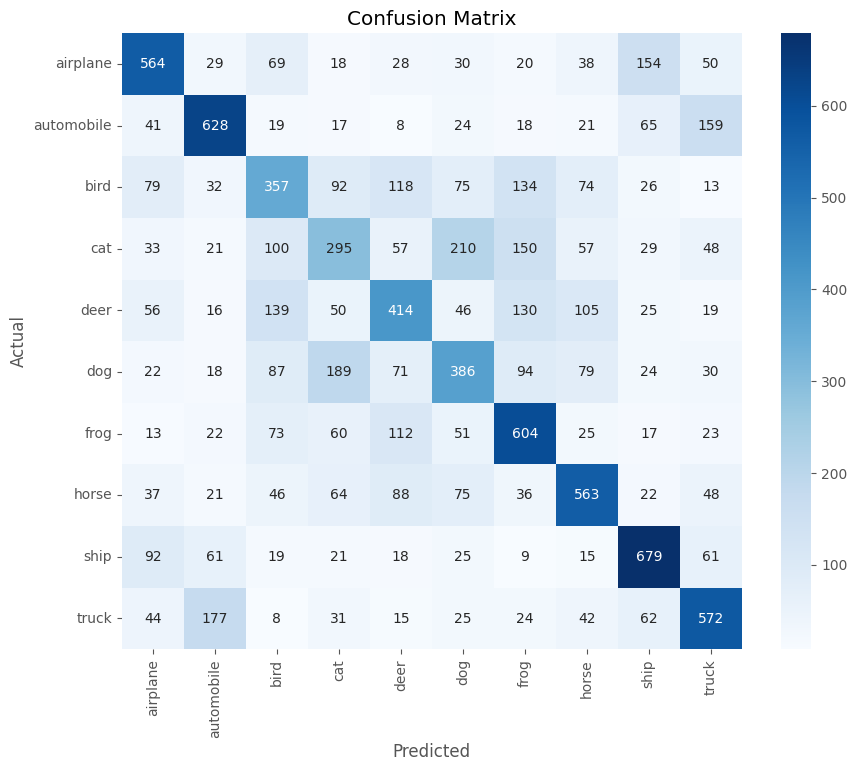

In [ ]:
# Define class labels for CIFAR-10 dataset
num_classes = 10  
class_labels = ["airplane", "automobile", "bird", "cat", "deer", 
                "dog", "frog", "horse", "ship", "truck"]

# Make predictions for the test dataset
y_pred_probs = model.predict(test_dataset)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get predicted class labels by selecting the index with the highest probability

# Get the true labels from the test dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Concatenate all true labels
y_true = np.argmax(y_true, axis=1)  # Convert true labels from one-hot encoding to class labels

# Compute overall accuracy using TensorFlow's Accuracy metric
accuracy_metric = tf.keras.metrics.Accuracy()
accuracy_metric.update_state(y_true, y_pred)  # Update the accuracy metric with true and predicted labels
tf_accuracy = accuracy_metric.result().numpy()  # Get the final accuracy result

# Initialize lists for storing class-wise precision and recall
precision = []
recall = []

# Convert predictions and true labels to one-hot encoding for class-wise metrics
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes)  # Convert true labels to one-hot encoding
y_pred_one_hot = tf.keras.utils.to_categorical(y_pred, num_classes)  # Convert predicted labels to one-hot encoding

# Calculate precision and recall for each class
for i in range(num_classes):
    precision_metric = tf.keras.metrics.Precision()  # Initialize precision metric for class i
    recall_metric = tf.keras.metrics.Recall()  # Initialize recall metric for class i
    
    # Update precision and recall for each class
    precision_metric.update_state(y_true_one_hot[:, i], y_pred_one_hot[:, i])
    recall_metric.update_state(y_true_one_hot[:, i], y_pred_one_hot[:, i])
    
    # Append the precision and recall values to their respective lists
    precision.append(precision_metric.result().numpy())
    recall.append(recall_metric.result().numpy())

# Calculate macro-average precision and recall
precision = np.mean(precision)  # Calculate mean precision across all classes
recall = np.mean(recall)  # Calculate mean recall across all classes

# Calculate F1-Score using the formula: 2 * (precision * recall) / (precision + recall)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print overall performance metrics
print(f"Accuracy: {tf_accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-Score (macro): {f1_score:.4f}")

# Compute the confusion matrix to evaluate class-wise performance
conf_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix.numpy(), annot=True, fmt="d", cmap="Blues",  # Use seaborn to plot the heatmap
            xticklabels=class_labels, yticklabels=class_labels)  
plt.xlabel("Predicted")  # Label for the x-axis (Predicted class)
plt.ylabel("Actual")  # Label for the y-axis (True class)
plt.title("Confusion Matrix")  # Title for the confusion matrix plot
plt.show()  


# Further Usage

In [13]:
from tensorflow.keras.models import load_model
# Save model
model.save('../models/tensorflow_model.h5')

# Load model
loadedModel=tf.keras.models.load_model('../models/tensorflow_model.h5')
loadedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               786688    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 64ms/step


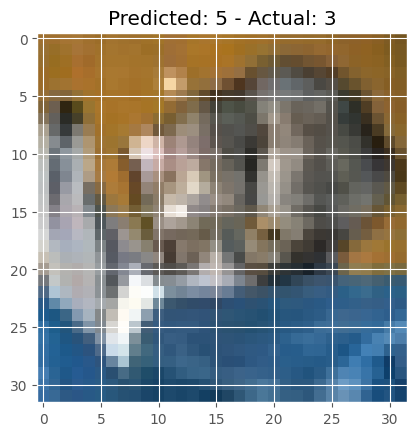

In [ ]:
single_image = X_test[0] # First image in the test set
# Reshape the image to match the input shape for the model (1, 3072)
single_image = single_image.reshape(1, 3072) 

# Get the model's prediction for the selected image
output = loadedModel.predict(single_image)

# show image
plt.imshow(single_image.reshape(32, 32, 3))
y_test = np.argmax(y_test, axis=1) 

# Display the predicted and actual class labels in the title
plt.title(f'Predicted: {np.argmax(output[0])} - Actual: {y_test[0]}') 
plt.show()


GPU usage

In [ ]:
import GPUtil as GPU

# GPU usage
GPUs = GPU.getGPUs()
for gpu in GPUs:
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

GPU RAM Free: 2087MB | Used: 1878MB | Util  46% | Total 4096MB
